In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import torch

#from itertools import product
from pynwb import NWBHDF5IO
from nlb_tools.nwb_interface import NWBDataset

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 'dandi download' downloads the data in this folder:
datapath = 'data/000128/sub-Jenkins/'
dataset = NWBDataset(datapath)

# Extract neural data and lagged hand velocity.
binsize = 5 #ms
dataset.resample(binsize)

trial_info = dataset.trial_info

# Combining the number of columns in the 'spikes' field with those in the 'heldout_spikes' field gives the total number of neurons.

n_null_trials = trial_info.isnull().sum()['success']
n_neurons = dataset.data.spikes.values.shape[1] + dataset.data.heldout_spikes.values.shape[1]

print(f'number of neurons: {n_neurons}')
print(f'total number of trials: {len(trial_info)}')
print(f'number of null trials: {n_null_trials}')

number of neurons: 182
total number of trials: 2869
number of null trials: 574


In [3]:
trial_info

,trial_id,start_time,end_time,move_onset_time,split,trial_type,trial_version,maze_id,success,target_on_time,go_cue_time,rt,delay,num_targets,target_pos,num_barriers,barrier_pos,active_target
0,0,0 days 00:00:00,0 days 00:00:00.700000,0 days 00:00:00.250000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0 days 00:00:00.800000,0 days 00:00:01.500000,0 days 00:00:01.050000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0 days 00:00:01.600000,0 days 00:00:02.300000,0 days 00:00:01.850000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0 days 00:00:02.400000,0 days 00:00:03.100000,0 days 00:00:02.650000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0 days 00:00:03.200000,0 days 00:00:03.900000,0 days 00:00:03.450000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,2864,0 days 02:03:15.800000,0 days 02:03:18.996000,0 days 02:03:17.785000,train,34.0,1.0,91.0,True,0 days 02:03:16.562000,0 days 02:03:17.477000,308.0,915.0,1.0,"[[116, -77]]",7.0,"[[66, -43, 30, 9], [-66, 1, 11, 70], [-35, 50,...",0.0
2865,2865,0 days 02:03:19.100000,0 days 02:03:21.936000,0 days 02:03:20.841000,train,15.0,1.0,75.0,True,0 days 02:03:19.917000,0 days 02:03:20.465000,376.0,548.0,1.0,"[[133, -81]]",9.0,"[[-33, 47, 37, 6], [-77, 48, 61, 11], [-64, -2...",0.0
2866,2866,0 days 02:03:22,0 days 02:03:24.966000,0 days 02:03:23.914000,train,23.0,0.0,67.0,True,0 days 02:03:22.665000,0 days 02:03:23.596000,318.0,931.0,1.0,"[[94, -86]]",0.0,[],0.0
2867,2867,0 days 02:03:25,0 days 02:03:28.401000,0 days 02:03:26.816000,val,25.0,2.0,84.0,True,0 days 02:03:25.831000,0 days 02:03:25.863000,953.0,32.0,3.0,"[[-111, -82], [-108, 81], [118, 72]]",8.0,"[[69, 31, 14, 99], [69, 54, 5, 101], [-62, -48...",2.0


In [5]:
for column in trial_info.columns:
    print(column)

trial_id
start_time
end_time
move_onset_time
split
trial_type
trial_version
maze_id
success
target_on_time
go_cue_time
rt
delay
num_targets
target_pos
num_barriers
barrier_pos
active_target


In [6]:
# Note that there is a number of trials at the begining of the session(s) that has no metadata at all.
# The NWBDataset function: make_trial_data() drops all of those.

print(f"Total num of trials: {len(trial_info)}\n")
print("Count of null values in each column:\n")

trial_info.isnull().sum()

Total num of trials: 2869

Count of null values in each column:



trial_id             0
start_time           0
end_time             0
move_onset_time      0
split                0
trial_type         574
trial_version      574
maze_id            574
success            574
target_on_time     574
go_cue_time        574
rt                 574
delay              574
num_targets        574
target_pos         574
num_barriers       574
barrier_pos        574
active_target      574
dtype: int64

In [7]:
# Number of all time bins in the entire dataset.
# That's right, each row is the measures in one time bin.
# Also, the original sampling rate is 100Hz (10ms bin size).
# Keep in mind that not all the trials are the same length.

len(dataset.data)

1481700

In [8]:
# The make_trial_data() returns a DataFrame containing trialized data. It has the same fields as the continuous `dataset.data` DataFrame,
# But adds `trial_id`, `trial_time`, and `align_time`. Till here, each row is still a time bin.
# Note: Later we do the cropping and alignment arount move_onset by ourselves.

trial_data = dataset.make_trial_data()
len(trial_data)

NaNs found in `self.data`. Dropping 5.57% of points to remove NaNs from `trial_data`.


1363219

In [9]:
trial_data

align_time             clock_time  cursor_pos             \
                                                                x          y   
80360          0 days 00:00:00 0 days 00:07:39.200000   -0.906088  -5.697308   
80361   0 days 00:00:00.005000 0 days 00:07:39.205000   -0.895789  -5.594303   
80362   0 days 00:00:00.010000 0 days 00:07:39.210000   -0.803879  -5.406166   
80363   0 days 00:00:00.015000 0 days 00:07:39.215000   -0.795907  -5.290990   
80364   0 days 00:00:00.020000 0 days 00:07:39.220000   -0.802702  -5.107678   
...                        ...                    ...         ...        ...   
1443574 0 days 00:00:03.380000 0 days 02:03:28.380000  116.832794  64.352584   
1443575 0 days 00:00:03.385000 0 days 02:03:28.385000  117.390347  64.659302   
1443576 0 days 00:00:03.390000 0 days 02:03:28.390000  116.775256  64.321979   
1443577 0 days 00:00:03.395000 0 days 02:03:28.395000  117.451182  64.692401   
1443578 0 days 00:00:03.400000 0 days 02:03:28.400000  116.717743  64.287988   

            eye_pos               hand_pos             hand_vel             \
                  x          y           x          y         x          y   
80360      7.109167   1.877142   -0.715989 -40.511794 -2.686373  30.346761   
80361      8.138759   1.992930   -0.729059 -40.366844 -3.090014  34.779373   
80362      7.880163   2.643959   -0.743743 -40.178431 -2.342974  39.244896   
80363      7.000067   2.681954   -0.749427 -39.974609  0.334714  42.659592   
80364      8.491252   2.597340   -0.738312 -39.752586  4.302140  45.765978   
...             ...        ...         ...        ...       ...        ...   
1443574 -120.657537  35.711611  116.866947  29.466638  1.713174  -3.606367   
1443575 -122.473366  35.269390  117.447701  29.588437  2.257167  -4.917210   
1443576 -121.065276  35.979646  116.831827  29.403931  0.753604  -6.245135   
1443577 -122.616627  35.559383  117.511151  29.540947 -2.602032  -7.253991   
1443578 -122.420767  35.724041  116.744659  29.320171 -5.360179  -7.412314   

         ... spikes                                    trial_id  \
         ...   2861 2862 2871 2881 2911 2931 2951 2961            
80360    ...    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      574   
80361    ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      574   
80362    ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      574   
80363    ...    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      574   
80364    ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      574   
...      ...    ...  ...  ...  ...  ...  ...  ...  ...      ...   
1443574  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     2867   
1443575  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     2867   
1443576  ...    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     2867   
1443577  ...    0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0     2867   
1443578  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     2867   

                    trial_time  
                                
80360          0 days 00:00:00  
80361   0 days 00:00:00.005000  
80362   0 days 00:00:00.010000  
80363   0 days 00:00:00.015000  
80364   0 days 00:00:00.020000  
...                        ...  
1443574 0 days 00:00:03.380000  
1443575 0 days 00:00:03.385000  
1443576 0 days 00:00:03.390000  
1443577 0 days 00:00:03.395000  
1443578 0 days 00:00:03.400000  

[1363219 rows x 195 columns]

In [10]:
trial_info[trial_info['success'] == False]

,trial_id,start_time,end_time,move_onset_time,split,trial_type,trial_version,maze_id,success,target_on_time,go_cue_time,rt,delay,num_targets,target_pos,num_barriers,barrier_pos,active_target


In [11]:
trial_info['active_target'].value_counts()

active_target
0.0    1786
2.0     256
1.0     253
Name: count, dtype: int64

In [12]:
np.isnan(trial_data['spikes'].to_numpy().flatten()).any()

np.False_

<function matplotlib.pyplot.show(close=None, block=None)>

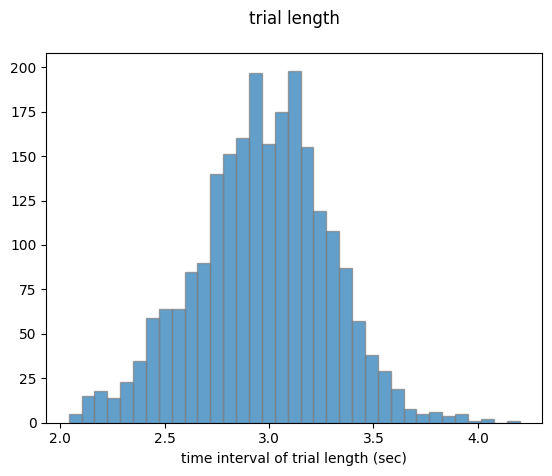

In [13]:
trial_lens = []

for trial_id, trial in trial_data.groupby('trial_id'):
    trial_id_trial_info = trial_info[trial_info['trial_id'] == trial_id]
    
    trial_lens.append((trial.trial_time.values[-1] / np.timedelta64(1, 's')) - (trial.trial_time.values[0] / np.timedelta64(1, 's')))
    
plt.hist(trial_lens, bins='auto', density=False, alpha=0.7, edgecolor='gray')

plt.title('trial length\n')
plt.xlabel('time interval of trial length (sec)')
plt.savefig('output_figs/tl.png')
plt.show

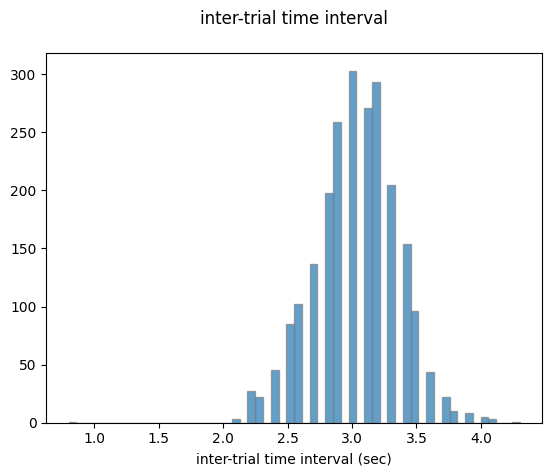

In [14]:
trials = [trial[1] for trial in trial_data.groupby('trial_id')]
inter_trial_intervals = []
    
for i, trial in enumerate(trials):
    trial_id = i + n_null_trials - 1
    trial_id_next = i + 1 + n_null_trials - 1
    trial_id_trial_info = trial_info[trial_info['trial_id'] == trial_id]
    trial_id_trial_info_next = trial_info[trial_info['trial_id'] == trial_id_next]
    
    inter_trial_intervals.append((trial_id_trial_info_next['start_time'].iloc[0] / np.timedelta64(1, 's')) - (trial_id_trial_info['start_time'].iloc[0] / np.timedelta64(1, 's')))
    
plt.hist(inter_trial_intervals, bins='auto', density=False, alpha=0.7, edgecolor='gray')

plt.title('inter-trial time interval\n')
plt.xlabel('inter-trial time interval (sec)')
plt.savefig('output_figs/iit.png')
plt.show()

In [15]:
len(trials)

2294

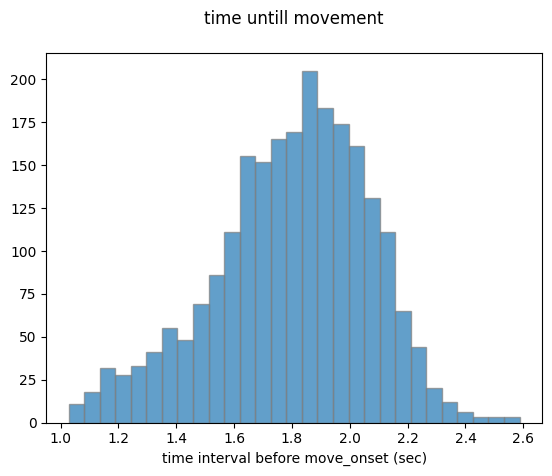

In [16]:
time_utill_move = []

for i, _ in enumerate(trials):
    trial_id = i + n_null_trials
    trial_id_trial_info = trial_info[trial_info['trial_id'] == trial_id]
    
    time_utill_move.append((trial_id_trial_info['move_onset_time'].iloc[0] / np.timedelta64(1, 's')) - (trial_id_trial_info['start_time'].iloc[0] / np.timedelta64(1, 's')))
    
plt.hist(time_utill_move, bins='auto', density=False, alpha=0.7, edgecolor='gray')
plt.title('time untill movement\n')
plt.xlabel('time interval before move_onset (sec)')
plt.savefig('output_figs/tibm.png')
plt.show()

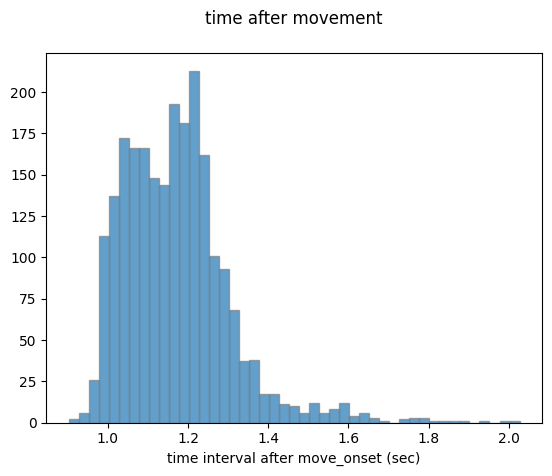

In [17]:
time_after_move = []

for i, _ in enumerate(trials):
    trial_id = i + n_null_trials
    trial_id_trial_info = trial_info[trial_info['trial_id'] == trial_id]
    
    time_after_move.append((trial_id_trial_info['end_time'].iloc[0] / np.timedelta64(1, 's')) - (trial_id_trial_info['move_onset_time'].iloc[0] / np.timedelta64(1, 's')))
    
plt.hist(time_after_move, bins='auto', density=False, alpha=0.7, edgecolor='gray')
plt.title('time after movement\n')
plt.xlabel('time interval after move_onset (sec)')
plt.savefig('output_figs/tiam.png')
plt.show()

### Forming conditions

In [19]:
def get_simple_cond(angle):
        
    if 350 <= angle < 360 or 0 <= angle < 38:
        return 0
    elif 38 <= angle < 125:
        return 1
    elif 125 <= angle < 175:
        return 2
    elif 175 <= angle < 212:
        return 3
    elif 212 <= angle < 232:
        return 4
    elif 232 <= angle < 280:
        return 5
    elif 280 <= angle <= 329:
        return 6
    elif 329 <= angle <= 350:
        return 7
    else:
        raise ValueError("Angle out of range")

def n_unigue_conds(trial_conds):
    # Convert each list to a frozenset and use a set to track unique frozensets
    unique_conds = set(frozenset(cond) for cond in trial_conds)
    return len(unique_conds)

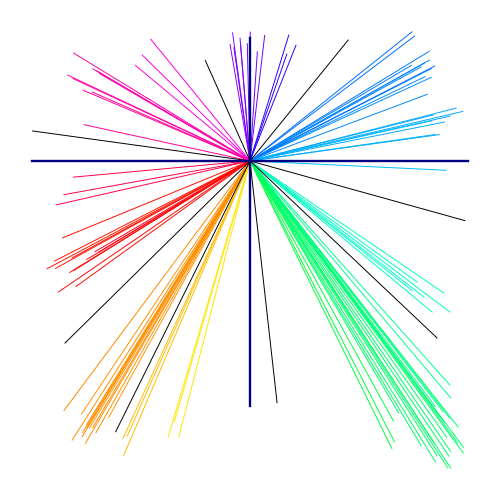

In [20]:
## Plot trial-averaged reaches

# Find unique conditions
conds = trial_info.set_index(['trial_type', 'trial_version']).index.unique().tolist()
conds = [cond for cond in conds if not any(math.isnan(x) for x in cond)]

# Initialize plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Loop over conditions and compute average trajectory
for cond in conds:
    # Find trials in condition
    mask = np.all(trial_info[['trial_type', 'trial_version']] == cond, axis=1)
    # Extract trial data
    trial_d = dataset.make_trial_data(ignored_trials=(~mask))
    # Average hand position across trials
    traj = trial_d.groupby('align_time')[[('hand_pos', 'x'), ('hand_pos', 'y')]].mean().to_numpy()
    # Determine reach angle for color
    active_target = trial_info[mask].target_pos.iloc[0][int(dataset.trial_info[mask].active_target.iloc[0])]
    reach_angle = np.arctan2(*active_target[::-1])
    # Plot reach
    ax.plot([0, traj[:, 0][-1]], [0, traj[:, 1][-1]], linewidth=0.7, color=plt.cm.hsv(reach_angle / (2*np.pi) + 0.5))

angle_radians = np.radians(350)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')
'''
angle_radians = np.radians(16)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')
'''
angle_radians = np.radians(38)
x_end = 80 * np.cos(angle_radians)
y_end = 80 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')

angle_radians = np.radians(125)
x_end = 50 * np.cos(angle_radians)
y_end = 50 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')

angle_radians = np.radians(175)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')
'''
angle_radians = np.radians(193)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')
'''
angle_radians = np.radians(212)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')

angle_radians = np.radians(232)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')

angle_radians = np.radians(280)
x_end = 100 * np.cos(angle_radians)
y_end = 100 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')

angle_radians = np.radians(329)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')

angle_radians = np.radians(0)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=1.7, color='navy')

angle_radians = np.radians(90)
x_end = 50 * np.cos(angle_radians)
y_end = 50 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=1.7, color='navy')

angle_radians = np.radians(180)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=1.7, color='navy')

angle_radians = np.radians(270)
x_end = 100 * np.cos(angle_radians)
y_end = 100 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=1.7, color='navy')

plt.axis('off')
plt.show()

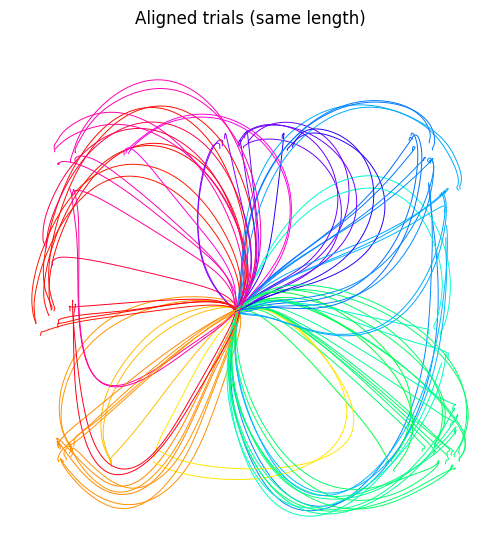

In [21]:
## Plot trial-averaged reaches

# Find unique conditions
maze_conds = trial_info.set_index(['trial_type', 'trial_version']).index.unique().tolist()
maze_conds = [cond for cond in maze_conds if not any(math.isnan(x) for x in cond)]

orig_conds = {}
simp_conds = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}

fig = plt.figure(figsize=(6, 6))
fig.suptitle('Aligned trials (same length)')
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Loop over conditions and compute average trajectory
for cond_idx, cond in enumerate(maze_conds):
    # Find trials in condition
    mask = np.all(dataset.trial_info[['trial_type', 'trial_version']] == cond, axis=1)
    trial_d = dataset.make_trial_data(align_field='move_onset_time', align_range=(-240, 660), ignored_trials=(~mask))
    traj = trial_d.groupby('align_time')[[('hand_pos', 'x'), ('hand_pos', 'y')]].mean().to_numpy()
    # Determine reach angle for color
    reach_angle = np.arctan2(*trial_info[mask].target_pos.iloc[0][int(trial_info[mask].active_target.iloc[0])][::-1])
    # Plot reach
    ax.plot(traj[:, 0], traj[:, 1], linewidth=0.7, color=plt.cm.hsv(reach_angle / (2*np.pi) + 0.5))
    
    orig_conds[cond_idx] = trial_d.trial_id.drop_duplicates().values
    simp_conds[get_simple_cond(math.degrees(reach_angle) + 360 / 2)].append(trial_d.trial_id.drop_duplicates().values)

simp_conds = {key: np.concatenate(value) for key, value in simp_conds.items()}
    
plt.axis('off')
plt.show()

In [22]:
conds = []
for trial_id, trial in trial_data.groupby('trial_id'):
    trial_id_trial_info = trial_info[trial_info['trial_id'] == trial_id]
    
    for cond, trial_ids in orig_conds.items():
        if trial_id in trial_ids:
            conds.append(cond)
            break
            
maze_conds = torch.tensor(maze_conds)
conds = torch.tensor(conds)

print(maze_conds.shape)
print(conds.shape)

torch.Size([108, 2])
torch.Size([2294])


In [23]:
_, cond_counts = torch.unique(conds, return_counts=True)
cond_counts

tensor([22, 24, 18, 25, 25, 23, 22, 27, 19, 26, 23, 24, 18, 17, 23, 18, 21, 24,
        20, 21, 20, 22, 18, 19, 25, 25, 20, 23, 24, 24, 21, 21, 22, 22, 19, 22,
        20, 20, 20, 18, 22, 21, 19, 22, 22, 22, 23, 22, 21, 21, 26, 19, 24, 22,
        20, 19, 20, 19, 24, 22, 22, 22, 20, 22, 21, 22, 18, 22, 23, 22, 20, 24,
        19, 19, 21, 21, 22, 18, 17, 22, 22, 22, 24, 18, 22, 21, 19, 19, 22, 22,
        21, 22, 21, 21, 19, 20, 20, 19, 22, 22, 23, 20, 20, 22, 22, 20, 19, 18])

## Forming trials and label vectors

In [25]:
#[col for col in trial_data.columns if any(_ in col for _ in ['vel', 'pos', 'force', 'acc', 'target'])]
label_cols = [col for col in trial_data.columns if any(_ in col for _ in ['x', 'y'])]

In [26]:
label_cols

[('cursor_pos', 'x'),
 ('cursor_pos', 'y'),
 ('eye_pos', 'x'),
 ('eye_pos', 'y'),
 ('hand_pos', 'x'),
 ('hand_pos', 'y'),
 ('hand_vel', 'x'),
 ('hand_vel', 'y')]

In [61]:
# Align the trials arount the move_onset bin with offsets before and after that bin.
y = []
labels = []
target_pos = []
active_target = []
conds = []

# We want total trial length of 900ms, which is 90 time bins.
bins_before_move = 48
bins_after_move = 132

trial_length = bins_before_move + bins_after_move
n_trials = trial_data.shape[0] // trial_length

for trial_id, trial in trial_data.groupby('trial_id'):
    trial_id_info = trial_info[trial_info['trial_id'] == trial_id]
            
    # Get the untill movement in ms.
    move_time = (trial_id_info['move_onset_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))
    # Get the number of bins until movement.
    move_bin = int(move_time // binsize)

    y_heldin_t = torch.tensor(trial.spikes.values)
    y_heldout_t = torch.tensor(trial.heldout_spikes.values)
    
    # Crop the trials arount the move_onset bin with offsets before and after that bin.
    y_t = torch.concat(
        [y_heldin_t[move_bin-bins_before_move:move_bin+bins_after_move, :], y_heldout_t[move_bin-bins_before_move:move_bin+bins_after_move, :]], dim=-1
    )
    
    y.append(y_t.reshape(1, trial_length, n_neurons))
    labels.append(torch.tensor(trial.cursor_pos.values[move_bin-bins_before_move:move_bin+bins_after_move, :]).reshape(1, trial_length, 2))
    
    target_pos.append(trial_id_info.target_pos.values[0])
    active_target.append(int(trial_id_info.active_target.values[0]))
    
    for cond, trial_ids in orig_conds.items():
        if trial_id in trial_ids:
            conds.append(cond)
    
y = torch.concat(y, dim=0)
labels = torch.concat(labels, dim=0)
conds = torch.tensor(conds)
active_target = torch.tensor(active_target)

print(y.shape)
print(labels.shape)
print(conds.shape)
print(len(target_pos))
print(active_target.shape)

torch.Size([2294, 180, 182])
torch.Size([2294, 180, 2])
torch.Size([2294])
2294
torch.Size([2294])


### Forming events occurance time bins

In [74]:
for i, _ in enumerate(trials):
    trial_id = i + n_null_trials
    trial_id_trial_info = trial_info[trial_info['trial_id'] == trial_id]
    
    target_on = (((trial_id_trial_info['target_on_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)
    gocue = (((trial_id_trial_info['go_cue_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)
    move_onset = (((trial_id_trial_info['move_onset_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)

In [75]:
target_bins = []
gocue_bins = []
move_bins = []
event_bins = []

for i, _ in enumerate(trials):
    trial_id = i + n_null_trials
    trial_id_trial_info = trial_info[trial_info['trial_id'] == trial_id]
    
    # target : go
    delay = (((trial_id_trial_info['go_cue_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_trial_info['target_on_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)
    # go : move
    prep = (((trial_id_trial_info['move_onset_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_trial_info['go_cue_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)
    
    target_on = (((trial_id_trial_info['target_on_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)
    gocue = (((trial_id_trial_info['go_cue_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)
    move_onset = (((trial_id_trial_info['move_onset_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)
    
    target_bins.append(target_on - move_onset + bins_before_move)
    gocue_bins.append(gocue - move_onset + bins_before_move)
    move_bins.append(bins_before_move)

event_bins.append(torch.tensor(target_bins))
event_bins.append(torch.tensor(gocue_bins))
event_bins.append(torch.tensor(move_bins))
event_bins = torch.stack(event_bins)
event_bins.shape

torch.Size([3, 2294])

In [76]:
event_bins = event_bins.permute(1, 0)

event_bins[event_bins < 0] = float('nan')
event_bins[event_bins > bins_before_move + bins_after_move] = float('nan')
event_bins.shape

torch.Size([2294, 3])

In [77]:
event_bins

tensor([[nan, nan, 48.],
        [nan, nan, 48.],
        [nan, nan, 48.],
        ...,
        [nan, nan, 48.],
        [nan, nan, 48.],
        [nan, nan, 48.]])

### Save data splits

In [86]:
import torch

!mkdir data
save_root_path = 'data/'

train_data, valid_data, test_data = {}, {}, {}
n_trials, seq_len, n_neurons = y.shape
n_valid_trials = 574

# obs: observations
train_data['y_obs'] = torch.Tensor(y[:-n_valid_trials])
valid_data['y_obs'] = torch.Tensor(y[-n_valid_trials:-n_valid_trials // 2])
test_data['y_obs'] = torch.Tensor(y[-n_valid_trials // 2:])

# 'n_bins_enc': Number of time bins used later by in modeling for enconding (default full trial).
# 'n_bins_obs': originaly observed trial length (after alignment)
# Same for 'n_neurons_obs' and 'n_neurons_enc'.
train_data['n_bins_obs'] = valid_data['n_bins_obs'] = test_data['n_bins_obs'] = seq_len
train_data['n_bins_enc'] = valid_data['n_bins_enc'] = test_data['n_bins_enc'] = seq_len
train_data['n_neurons_obs'] = valid_data['n_neurons_obs'] = test_data['n_neurons_obs'] = n_neurons
train_data['n_neurons_enc'] = valid_data['n_neurons_enc'] = test_data['n_neurons_enc'] = n_neurons

# Save a 1D array for event bins for each data split, for each trial, for each event.
# Note: the o here in event_bins[0] is the session-animal group.
for event_id, event in enumerate(['targrt_on_bin', 'go_cue_bin', 'move_onset_bin']):
    train_data[event] = torch.Tensor(np.array(event_bins[:-n_valid_trials, event_id]))
    valid_data[event] = torch.Tensor(np.array(event_bins[-n_valid_trials:-n_valid_trials // 2, event_id]))
    test_data[event] = torch.Tensor(np.array(event_bins[-n_valid_trials // 2:, event_id]))

train_data['hand_vel'] = torch.Tensor(np.array(labels[:-n_valid_trials, :, :]))
valid_data['hand_vel'] = torch.Tensor(np.array(labels[-n_valid_trials:-n_valid_trials // 2, :, :]))
test_data['hand_vel'] = torch.Tensor(np.array(labels[-n_valid_trials // 2:, :, :]))

train_data['conds'] = torch.Tensor(np.array(conds[:-n_valid_trials]))
valid_data['conds'] = torch.Tensor(np.array(conds[-n_valid_trials:-n_valid_trials // 2]))
test_data['conds'] = torch.Tensor(np.array(conds[-n_valid_trials // 2:]))

train_data['target_pos'] = target_pos[:-n_valid_trials]
valid_data['target_pos'] = target_pos[-n_valid_trials:-n_valid_trials // 2]
test_data['target_pos'] = target_pos[-n_valid_trials // 2:]

train_data['active_target'] = torch.Tensor(np.array(active_target[:-n_valid_trials]))
valid_data['active_target'] = torch.Tensor(np.array(active_target[-n_valid_trials:-n_valid_trials // 2]))
test_data['active_target'] = torch.Tensor(np.array(active_target[-n_valid_trials // 2:]))

'''
for label_id, label in enumerate(label_cols):
    train_data[f'{label[0]}_{label[1]}'] = torch.Tensor(np.array(labels[:-n_valid_trials, :, :]))
    valid_data[f'{label[0]}_{label[1]}'] = torch.Tensor(np.array(labels[-n_valid_trials:-n_valid_trials // 2, :, :]))
    test_data[f'{label[0]}_{label[1]}'] = torch.Tensor(np.array(labels[-n_valid_trials // 2:, :, :]))
'''
torch.save(train_data, save_root_path + f'data_train_{binsize}ms.pt')
torch.save(valid_data, save_root_path + f'data_valid_{binsize}ms.pt')
torch.save(test_data, save_root_path + f'data_test_{binsize}ms.pt')

print('Data splits (train/valid/test) saved into the "data" folder.')

mkdir: data: File exists
Data splits (train/valid/test) saved into the "data" folder.


## Load data splits

In [ ]:
data_path = 'data/data_{split}_{bin_sz_ms}ms.pt'
train_data = torch.load(data_path.format(split='train', bin_sz_ms=cfg.bin_sz_ms))
val_data = torch.load(data_path.format(split='valid', bin_sz_ms=cfg.bin_sz_ms))
test_data = torch.load(data_path.format(split='test', bin_sz_ms=cfg.bin_sz_ms))

y_train_obs = train_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_valid_obs = val_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_test_obs = test_data['y_obs'].type(torch.float32).to(cfg.data_device)

vel_train = train_data['velocity'].type(torch.float32).to(cfg.data_device)
vel_valid = val_data['velocity'].type(torch.float32).to(cfg.data_device)
vel_test = test_data['velocity'].type(torch.float32).to(cfg.data_device)

y_train_dataset = torch.utils.data.TensorDataset(y_train_obs, vel_train)
y_val_dataset = torch.utils.data.TensorDataset(y_valid_obs, vel_valid)
y_test_dataset = torch.utils.data.TensorDataset(y_test_obs, vel_test)

train_dataloader = torch.utils.data.DataLoader(y_train_dataset, batch_size=cfg.batch_sz, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(y_val_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)
test_dataloader = torch.utils.data.DataLoader(y_test_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)

# Data dimensions
n_train_trials, n_time_bins, n_neurons_obs = y_train_obs.shape
n_valid_trials = y_valid_obs.shape[0]
n_test_trials = y_test_obs.shape[0]
n_time_bins_enc = train_data['n_time_bins_enc']

batch_sz_train = list(y_train_obs.shape)[:-1]
batch_sz_valid = list(y_valid_obs.shape)[:-1]
batch_sz_test = list(y_test_obs.shape)[:-1]

print("# training trials: {0}".format(n_train_trials))
print("# validation trials: {0}".format(n_valid_trials))
print("# testing trials: {0}".format(n_test_trials))
print("# neurons: {0}".format(n_neurons_obs))
print("# time bins: {0}".format(n_time_bins))
print("# time bins used for forcasting: {0}".format(cfg.n_bins_bhv))
print("# predicted time bins: {0}".format(n_time_bins - cfg.n_bins_bhv))

### Reach variability

In [88]:
conds_ids, cond_counts = torch.unique(conds, return_counts=True)
cond_counts

tensor([22, 24, 18, 25, 25, 23, 22, 27, 19, 26, 23, 24, 18, 17, 23, 18, 21, 24,
        20, 21, 20, 22, 18, 19, 25, 25, 20, 23, 24, 24, 21, 21, 22, 22, 19, 22,
        20, 20, 20, 18, 22, 21, 19, 22, 22, 22, 23, 22, 21, 21, 26, 19, 24, 22,
        20, 19, 20, 19, 24, 22, 22, 22, 20, 22, 21, 22, 18, 22, 23, 22, 20, 24,
        19, 19, 21, 21, 22, 18, 17, 22, 22, 22, 24, 18, 22, 21, 19, 19, 22, 22,
        21, 22, 21, 21, 19, 20, 20, 19, 22, 22, 23, 20, 20, 22, 22, 20, 19, 18])

In [90]:
top_cs, top_ids = torch.topk(cond_counts, 5)
top_ids

tensor([ 7, 50,  9,  3,  4])

In [134]:
trial_info['num_targets']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
2864    1.0
2865    1.0
2866    1.0
2867    3.0
2868    1.0
Name: num_targets, Length: 2869, dtype: float64

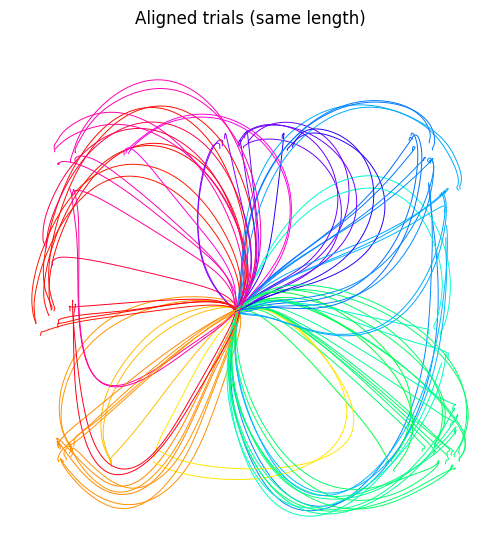

In [92]:
# Trial-averged 108 reach conditions

fig = plt.figure(figsize=(6, 6))
fig.suptitle('Aligned trials (same length)')
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Loop over conditions and compute average trajectory
for cond_idx, cond in enumerate([cond for cond in trial_info.set_index(['trial_type', 'trial_version']).index.unique().tolist() if not any(math.isnan(x) for x in cond)]):
    # Find trials in condition
    mask = np.all(dataset.trial_info[['trial_type', 'trial_version']] == cond, axis=1)
    trial_d = dataset.make_trial_data(align_field='move_onset_time', align_range=(-240, 660), ignored_trials=(~mask))
    traj = trial_d.groupby('align_time')[[('hand_pos', 'x'), ('hand_pos', 'y')]].mean().to_numpy()
    # Determine reach angle for color
    reach_angle = np.arctan2(*trial_info[mask].target_pos.iloc[0][int(trial_info[mask].active_target.iloc[0])][::-1])
    # Plot reach
    ax.plot(traj[:, 0], traj[:, 1], linewidth=0.7, color=plt.cm.hsv(reach_angle / (2*np.pi) + 0.5))
    
plt.axis('off')
plt.savefig('trial_averged_reaches_108')
plt.show()

In [99]:
y_data = y
y_vel = labels
y_conds = conds
y_t_pos = target_pos
act_t = active_target

In [100]:
def get_cond_trials(y_vel, y_conds):
    psth = np.zeros((len(conds_ids), y_vel.shape[1], y_vel.shape[2]))

    for cond in conds_ids:
        mask = y_conds == cond
        psth[cond, :, :] = y_vel[mask, :, :].mean(axis=0)
    
    return psth

def calc_var_to_mean_ratio(psth):
    v_m_ratio =  np.sum((psth.var(axis=0)) / (psth.mean(axis=0)), axis=0)
    
    return(np.nan_to_num(v_m_ratio, nan=0))

In [101]:
psth = get_cond_trials(y_vel, y_conds)

In [102]:
psth.shape

(108, 180, 2)

In [103]:
vmr = calc_var_to_mean_ratio(psth)

In [104]:
vmr

array([  57284.25618751, -319179.54165195])

In [132]:
psth[0, 0, :]

array([-1.14912322, -2.64514294])

In [121]:
# Compute the variance for each tensor along the specified dimension
var = [t.var(axis=0).mean().item() for t in psth[0, :, :]]

In [130]:
var

[0.5595187481675514,
 0.5788914439212908,
 0.5759841073348106,
 0.5692365215691535,
 0.5751935884435675,
 0.569367028575041,
 0.5752097722664602,
 0.5790587700881271,
 0.5791420617537997,
 0.5745269432333353,
 0.5798664404498546,
 0.5942747991813007,
 0.5763821299252923,
 0.5766239526327579,
 0.5823770255198369,
 0.5868188024030783,
 0.5850853225148027,
 0.5859894096650451,
 0.581008555899613,
 0.5780547522088467,
 0.5660736361189644,
 0.5776748335749289,
 0.5810534646761651,
 0.5811228382049871,
 0.5998848670842554,
 0.6045713221873253,
 0.6200262096711888,
 0.6348075176250929,
 0.648226395272002,
 0.6508927893350822,
 0.6472619510067041,
 0.6603826753245186,
 0.6601905285516435,
 0.6597236833928163,
 0.6656807145318484,
 0.6661316037984988,
 0.6834023738461132,
 0.6983619449916537,
 0.7014216750692935,
 0.7207041888810436,
 0.7263681414029537,
 0.7130962399177869,
 0.7171149492139515,
 0.7083806320101912,
 0.7168512730681629,
 0.7224489994183314,
 0.712419644138131,
 0.72599118164388

In [128]:
np.array(var).shape

(180,)

In [119]:
psth[0, :, :].shape

(180, 2)

In [ ]:


# Sort the tensors based on the calculated variances
sorted_tensors = [tensor for _, tensor in sorted(zip(variances, tensors), key=lambda x: x[0])]

# Output the sorted tensors
for i, tensor in enumerate(sorted_tensors):
    print(f"Tensor {i+1}:\n{tensor}\n")

In [ ]:
psth[0, :, :]